In [1]:
# For version check
from platform import python_version
from importlib.metadata import version

In [4]:
import re
import time
import os
from concurrent.futures import ThreadPoolExecutor

import pandas as pd
import pylab as plt
import numpy as np
import seaborn as sns

import requests
from bs4 import BeautifulSoup

import Bio
from Bio import Phylo, SeqIO, Entrez
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq

import networkx as nx
# import igraph
from ete3 import NCBITaxa

In [7]:
print('Python: ', python_version())

print('numpy: ', version('numpy'))
print('pandas: ', pd.__version__)
print('seaborn: ', version('seaborn'))
print('matplotlib: ', version('matplotlib'))

print('networkx: ', nx.__version__)
print('Biopython: ', version('Biopython'))
print('ete3: ', version('ete3'))

print('requests: ', version('requests'))
print('BeautifulSoup: ', version('beautifulsoup4'))

Python:  3.10.1
numpy:  1.22.3
pandas:  1.4.2
seaborn:  0.11.2
matplotlib:  3.5.2
networkx:  2.8.1
Biopython:  1.79
ete3:  3.1.2
requests:  2.27.1
BeautifulSoup:  4.11.1


In [8]:
Entrez.email = 'burankova.y@gmail.com'

Using truncated TOL (https://itol.embl.de/) — leave only Eukaryotes.



## Contents:
1. [Truncate TOL](#TOL).
2. [Download *S. cerevisiae* genes](#Download).
3. [Download blast seq IDs](#seq_IDs)
4. [Prepare swiss DB](#prep_swiss)
5. [BLAST](#BLAST)
6. [Results](#Results)
7. [Results analysis](#analysis)

# 1. Truncate TOL <a name="TOL"></a>
 

In [9]:
tree = Phylo.read('../data/04_TOL/normal_newick.txt', "newick")
Phylo.draw_ascii(tree)

                     __________ Nanoarchaeum_equitans
                   _|
                  | |  _______ Pyrobaculum_aerophilum
                  | |_|
                  |   | _____ Aeropyrum_pernix
                  |   ||
                  |    |     __ Sulfolobus_solfataricus
                  |    |____|
              ____|         |_ Sulfolobus_tokodaii
             |    |
             |    |          , Thermoplasma_volcanium
             |    |  ________|
             |    | |        | Thermoplasma_acidophilum
             |    | |
             |    | |  ____ Archaeoglobus_fulgidus
             |    | |,|
             |    |_|||  _______ Halobacterium_sp._NRC-1
             |      |||_|
             |      ||  |   , Methanosarcina_acetivorans
             |      ||  |___|
             |      ||      | Methanosarcina_mazei
             |      ||
             |       |    , Pyrococcus_furiosus
  ___________|       | ___|
 |           |       ||   |, Pyrococcus_horikoshii
 |      

In [12]:
small_tree = tree.common_ancestor('Eukaryota', 'Saccharomyces_cerevisiae')
Phylo.draw_ascii(small_tree)

                        ____________________ Giardia_lamblia
                       |
                       |   _________________ Leishmania_major
_______________________|  |
                       |  |    ____________ Thalassiosira_pseudonana
                       |  |  ,|
                       |__|  ||      __________ Plasmodium_falciparum
                          |  ||_____|
                          |  |      |________ Cryptosporidium_hominis
                          |  |
                          |__|    ______________ Cyanidioschyzon_merolae
                             | __|
                             ||  |      __ Oryza_sativa
                             ||  |_____|
                             ||        |___ Arabidopsis_thaliana
                             ||
                              | ____________ Dictyostelium_discoideum
                              ||
                              ||       _________ Schizosaccharomyces_pombe
                              ||  

In [13]:
# save small tree
Phylo.write(small_tree, "../data/04_TOL/Eukaryota_tree.nwk", "newick")

1

In [14]:
# save list with terminal nodes of truncated tree
nodes_list = []

with open("../data/04_TOL/Eukaryota_tree_nodes.txt", 'w') as f:    
    for clade in small_tree.get_terminals():
        clade_str = ' '.join(clade.name.split('_'))
        nodes_list.append(clade_str)
        f.write(clade_str)
        f.write('\n')

# 2. Download *S. cerevisiae* genes <a name="Download"></a>
 

In [15]:
yeast_data = pd.read_csv('../data/01_GRNs/yeast.txt', sep='\t')

In [17]:
genes = set(yeast_data.Tf)
genes.update(yeast_data.Tg)

with open("../data/04_genes_lists/yeast/S_cerevisiae_genes.txt", 'w') as f: 
    f.write("\n".join(list(genes)))

In [18]:
genes_dict = dict.fromkeys(genes)
yeasts_genes = len(genes)

In [19]:
posted_genes = []

In [ ]:
YG_URL = "https://www.yeastgenome.org/search"

def fetch(gene_name):
    if genes_dict[gene_name]:
        return None, None
    
    posted_genes.append(gene_name)
    
    params = {
            'q': gene_name,
            'is_quick': 'true',
        }
    
    resp = requests.post(YG_URL, params=params)
    time.sleep(3)
    return resp.content, gene_name
    
    
pool = ThreadPoolExecutor(max_workers=10)
i = 1

for page, gene_name in pool.map(fetch, genes_dict):
    try:
        soup = BeautifulSoup(page, 'lxml')
        locusID = re.search(r'(?<=locusId: ").*(?=",\n)', soup.find('script').text).group(0)
        genes_dict[gene_name] = locusID
        
    except (IndexError, TypeError, AttributeError):
        continue
        
    finally:
        print(f'{i} / {yeasts_genes} [{i/yeasts_genes}]')
        i += 1

In [216]:
i = 0
for gene in genes_dict:
    if not genes_dict[gene]:
        i += 1
i

211

In [250]:
def fetch(gene_name):
    if gene_name in downloaded_genes:
        return None, None
    
    if not genes_dict[gene_name]:
        search_genes.append(gene_name)
        return None, None
    
    URL = os.path.join('https://www.yeastgenome.org/backend/locus/', genes_dict[gene_name], 'sequence_details')
    
    new_resp = requests.get(URL)
    search_genes.append(gene_name)
    time.sleep(3)
    
    return new_resp.content, gene_name
    
search_genes = []
downloaded_genes = [] 

pool = ThreadPoolExecutor(max_workers=10)
i = 1

for page, gene_name in pool.map(fetch, genes_dict):
    try:
        soup = BeautifulSoup(page, 'lxml')
        
        dnas = soup.find('p').text.split('coding_dna')[1]
        dna = dnas.split('"residues": "')[1].split('",')[0]
        
        with open("../data/genes_lists/S_cerevisiae_genes_seq.fa", "a") as output_handle:
            SeqIO.write(SeqRecord(Seq(dna), id = gene_name, description='S.cerevisiae'), output_handle, "fasta")
        
        downloaded_genes.append(gene_name)
        
    except (IndexError, TypeError, AttributeError):
        continue
        
    finally:
        print(f'{i} / {yeasts_genes} [{i/yeasts_genes}]')
        i += 1

0 / 4441 [0.0]
1 / 4441 [0.00022517451024544022]
2 / 4441 [0.00045034902049088043]
3 / 4441 [0.0006755235307363207]
4 / 4441 [0.0009006980409817609]
5 / 4441 [0.001125872551227201]
6 / 4441 [0.0013510470614726414]
7 / 4441 [0.0015762215717180816]
8 / 4441 [0.0018013960819635217]
9 / 4441 [0.002026570592208962]
10 / 4441 [0.002251745102454402]
11 / 4441 [0.0024769196126998424]
12 / 4441 [0.002702094122945283]
13 / 4441 [0.0029272686331907227]
14 / 4441 [0.003152443143436163]
15 / 4441 [0.003377617653681603]
16 / 4441 [0.0036027921639270434]
17 / 4441 [0.003827966674172484]
18 / 4441 [0.004053141184417924]
19 / 4441 [0.004278315694663364]
20 / 4441 [0.004503490204908804]
21 / 4441 [0.0047286647151542445]
22 / 4441 [0.004953839225399685]
23 / 4441 [0.005179013735645125]
24 / 4441 [0.005404188245890566]
25 / 4441 [0.005629362756136005]
26 / 4441 [0.0058545372663814455]
27 / 4441 [0.006079711776626886]
28 / 4441 [0.006304886286872326]
29 / 4441 [0.006530060797117767]
30 / 4441 [0.0067552353

250 / 4441 [0.056293627561360055]
251 / 4441 [0.05651880207160549]
252 / 4441 [0.05674397658185094]
253 / 4441 [0.056969151092096375]
254 / 4441 [0.05719432560234181]
255 / 4441 [0.05741950011258726]
256 / 4441 [0.057644674622832695]
257 / 4441 [0.05786984913307813]
258 / 4441 [0.05809502364332358]
259 / 4441 [0.058320198153569015]
260 / 4441 [0.05854537266381445]
261 / 4441 [0.0587705471740599]
262 / 4441 [0.058995721684305336]
263 / 4441 [0.05922089619455078]
264 / 4441 [0.05944607070479622]
265 / 4441 [0.059671245215041656]
266 / 4441 [0.0598964197252871]
267 / 4441 [0.06012159423553254]
268 / 4441 [0.060346768745777976]
269 / 4441 [0.06057194325602342]
270 / 4441 [0.06079711776626886]
271 / 4441 [0.061022292276514296]
272 / 4441 [0.06124746678675974]
273 / 4441 [0.06147264129700518]
274 / 4441 [0.06169781580725062]
275 / 4441 [0.06192299031749606]
276 / 4441 [0.0621481648277415]
277 / 4441 [0.06237333933798694]
278 / 4441 [0.06259851384823238]
279 / 4441 [0.06282368835847782]
280 /

500 / 4441 [0.11258725512272011]
501 / 4441 [0.11281242963296555]
502 / 4441 [0.11303760414321098]
503 / 4441 [0.11326277865345642]
504 / 4441 [0.11348795316370187]
505 / 4441 [0.11371312767394731]
506 / 4441 [0.11393830218419275]
507 / 4441 [0.11416347669443819]
508 / 4441 [0.11438865120468363]
509 / 4441 [0.11461382571492908]
510 / 4441 [0.11483900022517451]
511 / 4441 [0.11506417473541995]
512 / 4441 [0.11528934924566539]
513 / 4441 [0.11551452375591083]
514 / 4441 [0.11573969826615627]
515 / 4441 [0.11596487277640172]
516 / 4441 [0.11619004728664716]
517 / 4441 [0.11641522179689259]
518 / 4441 [0.11664039630713803]
519 / 4441 [0.11686557081738347]
520 / 4441 [0.1170907453276289]
521 / 4441 [0.11731591983787436]
522 / 4441 [0.1175410943481198]
523 / 4441 [0.11776626885836523]
524 / 4441 [0.11799144336861067]
525 / 4441 [0.11821661787885611]
526 / 4441 [0.11844179238910156]
527 / 4441 [0.118666966899347]
528 / 4441 [0.11889214140959244]
529 / 4441 [0.11911731591983787]
530 / 4441 [0.

751 / 4441 [0.16910605719432562]
752 / 4441 [0.16933123170457104]
753 / 4441 [0.1695564062148165]
754 / 4441 [0.16978158072506191]
755 / 4441 [0.17000675523530737]
756 / 4441 [0.1702319297455528]
757 / 4441 [0.17045710425579824]
758 / 4441 [0.1706822787660437]
759 / 4441 [0.17090745327628912]
760 / 4441 [0.17113262778653457]
761 / 4441 [0.17135780229678]
762 / 4441 [0.17158297680702544]
763 / 4441 [0.1718081513172709]
764 / 4441 [0.17203332582751632]
765 / 4441 [0.17225850033776177]
766 / 4441 [0.1724836748480072]
767 / 4441 [0.17270884935825265]
768 / 4441 [0.1729340238684981]
769 / 4441 [0.17315919837874352]
770 / 4441 [0.17338437288898897]
771 / 4441 [0.1736095473992344]
772 / 4441 [0.17383472190947985]
773 / 4441 [0.17405989641972527]
774 / 4441 [0.17428507092997073]
775 / 4441 [0.17451024544021618]
776 / 4441 [0.1747354199504616]
777 / 4441 [0.17496059446070705]
778 / 4441 [0.17518576897095248]
779 / 4441 [0.17541094348119793]
780 / 4441 [0.17563611799144338]
781 / 4441 [0.1758612

1003 / 4441 [0.22585003377617655]
1004 / 4441 [0.22607520828642197]
1005 / 4441 [0.22630038279666742]
1006 / 4441 [0.22652555730691284]
1007 / 4441 [0.2267507318171583]
1008 / 4441 [0.22697590632740375]
1009 / 4441 [0.22720108083764917]
1010 / 4441 [0.22742625534789462]
1011 / 4441 [0.22765142985814005]
1012 / 4441 [0.2278766043683855]
1013 / 4441 [0.22810177887863095]
1014 / 4441 [0.22832695338887637]
1015 / 4441 [0.22855212789912183]
1016 / 4441 [0.22877730240936725]
1017 / 4441 [0.2290024769196127]
1018 / 4441 [0.22922765142985815]
1019 / 4441 [0.22945282594010358]
1020 / 4441 [0.22967800045034903]
1021 / 4441 [0.22990317496059445]
1022 / 4441 [0.2301283494708399]
1023 / 4441 [0.23035352398108533]
1024 / 4441 [0.23057869849133078]
1025 / 4441 [0.23080387300157623]
1026 / 4441 [0.23102904751182166]
1027 / 4441 [0.2312542220220671]
1028 / 4441 [0.23147939653231253]
1029 / 4441 [0.23170457104255798]
1030 / 4441 [0.23192974555280343]
1031 / 4441 [0.23215492006304886]
1032 / 4441 [0.2323

1249 / 4441 [0.28124296329655485]
1250 / 4441 [0.28146813780680024]
1251 / 4441 [0.2816933123170457]
1252 / 4441 [0.28191848682729115]
1253 / 4441 [0.2821436613375366]
1254 / 4441 [0.28236883584778205]
1255 / 4441 [0.28259401035802745]
1256 / 4441 [0.2828191848682729]
1257 / 4441 [0.28304435937851835]
1258 / 4441 [0.2832695338887638]
1259 / 4441 [0.28349470839900925]
1260 / 4441 [0.28371988290925465]
1261 / 4441 [0.2839450574195001]
1262 / 4441 [0.28417023192974555]
1263 / 4441 [0.284395406439991]
1264 / 4441 [0.28462058095023646]
1265 / 4441 [0.28484575546048185]
1266 / 4441 [0.2850709299707273]
1267 / 4441 [0.28529610448097276]
1268 / 4441 [0.2855212789912182]
1269 / 4441 [0.28574645350146366]
1270 / 4441 [0.28597162801170906]
1271 / 4441 [0.2861968025219545]
1272 / 4441 [0.28642197703219996]
1273 / 4441 [0.2866471515424454]
1274 / 4441 [0.28687232605269086]
1275 / 4441 [0.28709750056293626]
1276 / 4441 [0.2873226750731817]
1277 / 4441 [0.28754784958342716]
1278 / 4441 [0.28777302409

1496 / 4441 [0.3368610673271786]
1497 / 4441 [0.337086241837424]
1498 / 4441 [0.3373114163476694]
1499 / 4441 [0.3375365908579149]
1500 / 4441 [0.3377617653681603]
1501 / 4441 [0.3379869398784058]
1502 / 4441 [0.33821211438865123]
1503 / 4441 [0.3384372888988966]
1504 / 4441 [0.3386624634091421]
1505 / 4441 [0.33888763791938753]
1506 / 4441 [0.339112812429633]
1507 / 4441 [0.33933798693987843]
1508 / 4441 [0.33956316145012383]
1509 / 4441 [0.3397883359603693]
1510 / 4441 [0.34001351047061473]
1511 / 4441 [0.3402386849808602]
1512 / 4441 [0.3404638594911056]
1513 / 4441 [0.34068903400135103]
1514 / 4441 [0.3409142085115965]
1515 / 4441 [0.34113938302184194]
1516 / 4441 [0.3413645575320874]
1517 / 4441 [0.3415897320423328]
1518 / 4441 [0.34181490655257823]
1519 / 4441 [0.3420400810628237]
1520 / 4441 [0.34226525557306914]
1521 / 4441 [0.3424904300833146]
1522 / 4441 [0.34271560459356]
1523 / 4441 [0.34294077910380544]
1524 / 4441 [0.3431659536140509]
1525 / 4441 [0.34339112812429634]
152

1743 / 4441 [0.3924791713578023]
1744 / 4441 [0.39270434586804776]
1745 / 4441 [0.39292952037829315]
1746 / 4441 [0.3931546948885386]
1747 / 4441 [0.39337986939878405]
1748 / 4441 [0.3936050439090295]
1749 / 4441 [0.39383021841927496]
1750 / 4441 [0.39405539292952035]
1751 / 4441 [0.3942805674397658]
1752 / 4441 [0.39450574195001126]
1753 / 4441 [0.3947309164602567]
1754 / 4441 [0.39495609097050216]
1755 / 4441 [0.39518126548074756]
1756 / 4441 [0.395406439990993]
1757 / 4441 [0.39563161450123846]
1758 / 4441 [0.3958567890114839]
1759 / 4441 [0.39608196352172936]
1760 / 4441 [0.39630713803197476]
1761 / 4441 [0.3965323125422202]
1762 / 4441 [0.39675748705246566]
1763 / 4441 [0.3969826615627111]
1764 / 4441 [0.39720783607295657]
1765 / 4441 [0.39743301058320196]
1766 / 4441 [0.3976581850934474]
1767 / 4441 [0.39788335960369287]
1768 / 4441 [0.3981085341139383]
1769 / 4441 [0.39833370862418377]
1770 / 4441 [0.39855888313442916]
1771 / 4441 [0.3987840576446746]
1772 / 4441 [0.399009232154

1990 / 4441 [0.44809727538842603]
1991 / 4441 [0.4483224498986715]
1992 / 4441 [0.44854762440891693]
1993 / 4441 [0.44877279891916233]
1994 / 4441 [0.4489979734294078]
1995 / 4441 [0.44922314793965323]
1996 / 4441 [0.4494483224498987]
1997 / 4441 [0.44967349696014414]
1998 / 4441 [0.44989867147038953]
1999 / 4441 [0.450123845980635]
2000 / 4441 [0.45034902049088044]
2001 / 4441 [0.4505741950011259]
2002 / 4441 [0.45079936951137134]
2003 / 4441 [0.45102454402161674]
2004 / 4441 [0.4512497185318622]
2005 / 4441 [0.45147489304210764]
2006 / 4441 [0.4517000675523531]
2007 / 4441 [0.4519252420625985]
2008 / 4441 [0.45215041657284394]
2009 / 4441 [0.4523755910830894]
2010 / 4441 [0.45260076559333484]
2011 / 4441 [0.4528259401035803]
2012 / 4441 [0.4530511146138257]
2013 / 4441 [0.45327628912407114]
2014 / 4441 [0.4535014636343166]
2015 / 4441 [0.45372663814456204]
2016 / 4441 [0.4539518126548075]
2017 / 4441 [0.4541769871650529]
2018 / 4441 [0.45440216167529834]
2019 / 4441 [0.45462733618554

2236 / 4441 [0.5034902049088044]
2237 / 4441 [0.5037153794190498]
2238 / 4441 [0.5039405539292952]
2239 / 4441 [0.5041657284395407]
2240 / 4441 [0.5043909029497861]
2241 / 4441 [0.5046160774600316]
2242 / 4441 [0.504841251970277]
2243 / 4441 [0.5050664264805224]
2244 / 4441 [0.5052916009907679]
2245 / 4441 [0.5055167755010133]
2246 / 4441 [0.5057419500112588]
2247 / 4441 [0.5059671245215042]
2248 / 4441 [0.5061922990317496]
2249 / 4441 [0.5064174735419951]
2250 / 4441 [0.5066426480522405]
2251 / 4441 [0.506867822562486]
2252 / 4441 [0.5070929970727314]
2253 / 4441 [0.5073181715829768]
2254 / 4441 [0.5075433460932223]
2255 / 4441 [0.5077685206034677]
2256 / 4441 [0.5079936951137132]
2257 / 4441 [0.5082188696239586]
2258 / 4441 [0.508444044134204]
2259 / 4441 [0.5086692186444495]
2260 / 4441 [0.5088943931546949]
2261 / 4441 [0.5091195676649404]
2262 / 4441 [0.5093447421751858]
2263 / 4441 [0.5095699166854312]
2264 / 4441 [0.5097950911956767]
2265 / 4441 [0.5100202657059221]
2266 / 4441 [

2487 / 4441 [0.5600090069804098]
2488 / 4441 [0.5602341814906553]
2489 / 4441 [0.5604593560009007]
2490 / 4441 [0.5606845305111461]
2491 / 4441 [0.5609097050213916]
2492 / 4441 [0.561134879531637]
2493 / 4441 [0.5613600540418825]
2494 / 4441 [0.5615852285521279]
2495 / 4441 [0.5618104030623733]
2496 / 4441 [0.5620355775726188]
2497 / 4441 [0.5622607520828642]
2498 / 4441 [0.5624859265931097]
2499 / 4441 [0.5627111011033551]
2500 / 4441 [0.5629362756136005]
2501 / 4441 [0.563161450123846]
2502 / 4441 [0.5633866246340914]
2503 / 4441 [0.5636117991443369]
2504 / 4441 [0.5638369736545823]
2505 / 4441 [0.5640621481648277]
2506 / 4441 [0.5642873226750732]
2507 / 4441 [0.5645124971853186]
2508 / 4441 [0.5647376716955641]
2509 / 4441 [0.5649628462058095]
2510 / 4441 [0.5651880207160549]
2511 / 4441 [0.5654131952263004]
2512 / 4441 [0.5656383697365458]
2513 / 4441 [0.5658635442467913]
2514 / 4441 [0.5660887187570367]
2515 / 4441 [0.5663138932672821]
2516 / 4441 [0.5665390677775276]
2517 / 4441 

2739 / 4441 [0.6167529835622607]
2740 / 4441 [0.6169781580725062]
2741 / 4441 [0.6172033325827516]
2742 / 4441 [0.6174285070929971]
2743 / 4441 [0.6176536816032425]
2744 / 4441 [0.6178788561134879]
2745 / 4441 [0.6181040306237334]
2746 / 4441 [0.6183292051339788]
2747 / 4441 [0.6185543796442243]
2748 / 4441 [0.6187795541544697]
2749 / 4441 [0.6190047286647151]
2750 / 4441 [0.6192299031749606]
2751 / 4441 [0.619455077685206]
2752 / 4441 [0.6196802521954514]
2753 / 4441 [0.6199054267056969]
2754 / 4441 [0.6201306012159423]
2755 / 4441 [0.6203557757261878]
2756 / 4441 [0.6205809502364332]
2757 / 4441 [0.6208061247466786]
2758 / 4441 [0.6210312992569241]
2759 / 4441 [0.6212564737671695]
2760 / 4441 [0.621481648277415]
2761 / 4441 [0.6217068227876604]
2762 / 4441 [0.6219319972979058]
2763 / 4441 [0.6221571718081513]
2764 / 4441 [0.6223823463183967]
2765 / 4441 [0.6226075208286422]
2766 / 4441 [0.6228326953388876]
2767 / 4441 [0.623057869849133]
2768 / 4441 [0.6232830443593785]
2769 / 4441 [

2990 / 4441 [0.6732717856338662]
2991 / 4441 [0.6734969601441116]
2992 / 4441 [0.6737221346543572]
2993 / 4441 [0.6739473091646025]
2994 / 4441 [0.674172483674848]
2995 / 4441 [0.6743976581850935]
2996 / 4441 [0.6746228326953388]
2997 / 4441 [0.6748480072055844]
2998 / 4441 [0.6750731817158298]
2999 / 4441 [0.6752983562260753]
3000 / 4441 [0.6755235307363207]
3001 / 4441 [0.675748705246566]
3002 / 4441 [0.6759738797568116]
3003 / 4441 [0.676199054267057]
3004 / 4441 [0.6764242287773025]
3005 / 4441 [0.6766494032875479]
3006 / 4441 [0.6768745777977933]
3007 / 4441 [0.6770997523080388]
3008 / 4441 [0.6773249268182842]
3009 / 4441 [0.6775501013285297]
3010 / 4441 [0.6777752758387751]
3011 / 4441 [0.6780004503490205]
3012 / 4441 [0.678225624859266]
3013 / 4441 [0.6784507993695114]
3014 / 4441 [0.6786759738797569]
3015 / 4441 [0.6789011483900023]
3016 / 4441 [0.6791263229002477]
3017 / 4441 [0.6793514974104932]
3018 / 4441 [0.6795766719207386]
3019 / 4441 [0.679801846430984]
3020 / 4441 [0.

3240 / 4441 [0.7295654131952263]
3241 / 4441 [0.7297905877054718]
3242 / 4441 [0.7300157622157172]
3243 / 4441 [0.7302409367259626]
3244 / 4441 [0.7304661112362081]
3245 / 4441 [0.7306912857464535]
3246 / 4441 [0.730916460256699]
3247 / 4441 [0.7311416347669444]
3248 / 4441 [0.7313668092771898]
3249 / 4441 [0.7315919837874353]
3250 / 4441 [0.7318171582976807]
3251 / 4441 [0.7320423328079262]
3252 / 4441 [0.7322675073181716]
3253 / 4441 [0.732492681828417]
3254 / 4441 [0.7327178563386625]
3255 / 4441 [0.7329430308489079]
3256 / 4441 [0.7331682053591534]
3257 / 4441 [0.7333933798693988]
3258 / 4441 [0.7336185543796442]
3259 / 4441 [0.7338437288898897]
3260 / 4441 [0.7340689034001351]
3261 / 4441 [0.7342940779103806]
3262 / 4441 [0.734519252420626]
3263 / 4441 [0.7347444269308714]
3264 / 4441 [0.7349696014411169]
3265 / 4441 [0.7351947759513623]
3266 / 4441 [0.7354199504616078]
3267 / 4441 [0.7356451249718532]
3268 / 4441 [0.7358702994820986]
3269 / 4441 [0.7360954739923441]
3270 / 4441 [

3490 / 4441 [0.7858590407565863]
3491 / 4441 [0.7860842152668318]
3492 / 4441 [0.7863093897770772]
3493 / 4441 [0.7865345642873227]
3494 / 4441 [0.7867597387975681]
3495 / 4441 [0.7869849133078135]
3496 / 4441 [0.787210087818059]
3497 / 4441 [0.7874352623283044]
3498 / 4441 [0.7876604368385499]
3499 / 4441 [0.7878856113487953]
3500 / 4441 [0.7881107858590407]
3501 / 4441 [0.7883359603692862]
3502 / 4441 [0.7885611348795316]
3503 / 4441 [0.7887863093897771]
3504 / 4441 [0.7890114839000225]
3505 / 4441 [0.7892366584102679]
3506 / 4441 [0.7894618329205134]
3507 / 4441 [0.7896870074307588]
3508 / 4441 [0.7899121819410043]
3509 / 4441 [0.7901373564512497]
3510 / 4441 [0.7903625309614951]
3511 / 4441 [0.7905877054717406]
3512 / 4441 [0.790812879981986]
3513 / 4441 [0.7910380544922315]
3514 / 4441 [0.7912632290024769]
3515 / 4441 [0.7914884035127223]
3516 / 4441 [0.7917135780229678]
3517 / 4441 [0.7919387525332132]
3518 / 4441 [0.7921639270434587]
3519 / 4441 [0.7923891015537041]
3520 / 4441 

3740 / 4441 [0.8421526683179464]
3741 / 4441 [0.8423778428281918]
3742 / 4441 [0.8426030173384373]
3743 / 4441 [0.8428281918486827]
3744 / 4441 [0.8430533663589281]
3745 / 4441 [0.8432785408691736]
3746 / 4441 [0.843503715379419]
3747 / 4441 [0.8437288898896644]
3748 / 4441 [0.8439540643999099]
3749 / 4441 [0.8441792389101553]
3750 / 4441 [0.8444044134204008]
3751 / 4441 [0.8446295879306462]
3752 / 4441 [0.8448547624408916]
3753 / 4441 [0.8450799369511371]
3754 / 4441 [0.8453051114613825]
3755 / 4441 [0.845530285971628]
3756 / 4441 [0.8457554604818734]
3757 / 4441 [0.8459806349921188]
3758 / 4441 [0.8462058095023643]
3759 / 4441 [0.8464309840126097]
3760 / 4441 [0.8466561585228553]
3761 / 4441 [0.8468813330331006]
3762 / 4441 [0.847106507543346]
3763 / 4441 [0.8473316820535916]
3764 / 4441 [0.847556856563837]
3765 / 4441 [0.8477820310740825]
3766 / 4441 [0.8480072055843279]
3767 / 4441 [0.8482323800945732]
3768 / 4441 [0.8484575546048188]
3769 / 4441 [0.8486827291150641]
3770 / 4441 [0

3992 / 4441 [0.8988966448997974]
3993 / 4441 [0.8991218194100428]
3994 / 4441 [0.8993469939202883]
3995 / 4441 [0.8995721684305337]
3996 / 4441 [0.8997973429407791]
3997 / 4441 [0.9000225174510246]
3998 / 4441 [0.90024769196127]
3999 / 4441 [0.9004728664715155]
4000 / 4441 [0.9006980409817609]
4001 / 4441 [0.9009232154920063]
4002 / 4441 [0.9011483900022518]
4003 / 4441 [0.9013735645124972]
4004 / 4441 [0.9015987390227427]
4005 / 4441 [0.9018239135329881]
4006 / 4441 [0.9020490880432335]
4007 / 4441 [0.902274262553479]
4008 / 4441 [0.9024994370637244]
4009 / 4441 [0.9027246115739699]
4010 / 4441 [0.9029497860842153]
4011 / 4441 [0.9031749605944607]
4012 / 4441 [0.9034001351047062]
4013 / 4441 [0.9036253096149516]
4014 / 4441 [0.903850484125197]
4015 / 4441 [0.9040756586354425]
4016 / 4441 [0.9043008331456879]
4017 / 4441 [0.9045260076559334]
4018 / 4441 [0.9047511821661788]
4019 / 4441 [0.9049763566764242]
4020 / 4441 [0.9052015311866697]
4021 / 4441 [0.9054267056969151]
4022 / 4441 [0

4242 / 4441 [0.9551902724611574]
4243 / 4441 [0.9554154469714028]
4244 / 4441 [0.9556406214816483]
4245 / 4441 [0.9558657959918937]
4246 / 4441 [0.9560909705021392]
4247 / 4441 [0.9563161450123846]
4248 / 4441 [0.95654131952263]
4249 / 4441 [0.9567664940328755]
4250 / 4441 [0.9569916685431209]
4251 / 4441 [0.9572168430533664]
4252 / 4441 [0.9574420175636118]
4253 / 4441 [0.9576671920738572]
4254 / 4441 [0.9578923665841027]
4255 / 4441 [0.9581175410943481]
4256 / 4441 [0.9583427156045936]
4257 / 4441 [0.958567890114839]
4258 / 4441 [0.9587930646250844]
4259 / 4441 [0.9590182391353299]
4260 / 4441 [0.9592434136455753]
4261 / 4441 [0.9594685881558208]
4262 / 4441 [0.9596937626660662]
4263 / 4441 [0.9599189371763116]
4264 / 4441 [0.9601441116865571]
4265 / 4441 [0.9603692861968025]
4266 / 4441 [0.960594460707048]
4267 / 4441 [0.9608196352172934]
4268 / 4441 [0.9610448097275388]
4269 / 4441 [0.9612699842377843]
4270 / 4441 [0.9614951587480297]
4271 / 4441 [0.9617203332582752]
4272 / 4441 [0

# 3. Download blast seq IDs <a name="seq_IDs"></a>
 

fore truncated blast DB

In [21]:
with open('../data/04_TOL/Eukaryota_tree_nodes.txt', 'r') as file:
    nodes = file.readlines()
    for i, node in enumerate(nodes):
        nodes_list[i] = node.strip()

Create dict with taxids:

In [22]:
ncbi = NCBITaxa()
name2taxid = ncbi.get_name_translator(nodes_list)

In [23]:
print(name2taxid)

{'Anopheles gambiae': [7165], 'Arabidopsis thaliana': [3702], 'Caenorhabditis briggsae': [6238], 'Caenorhabditis elegans': [6239], 'Cryptosporidium hominis': [237895], 'Cyanidioschyzon merolae': [45157], 'Danio rerio': [7955], 'Dictyostelium discoideum': [44689], 'Drosophila melanogaster': [7227], 'Eremothecium gossypii': [33169], 'Gallus gallus': [9031], 'Homo sapiens': [9606], 'Leishmania major': [5664], 'Mus musculus': [10090], 'Oryza sativa': [4530], 'Pan troglodytes': [9598], 'Plasmodium falciparum': [5833], 'Rattus norvegicus': [10116], 'Saccharomyces cerevisiae': [4932], 'Schizosaccharomyces pombe': [4896], 'Takifugu rubripes': [31033], 'Thalassiosira pseudonana': [35128], 'Giardia lamblia': [5741]}


In [24]:
with open('../data/04_TOL/Eukaryota_tree_nodes_taxID.txt', 'w') as f:
    for taxa in name2taxid:
        print(taxa, '\t', *name2taxid[taxa], file=f, end='\n')

Search the Entrez Protein database:

In [25]:
def protein_entrez(taxid):
    term = ''.join(['txid', taxid, '[ORGN]'])
    handle = Entrez.esearch(db="protein", term=term)
    record = Entrez.read(handle)
    
    try:
        count = record['Count']
        handle = Entrez.esearch(db="protein", term=term, retmax=count)
        record = Entrez.read(handle)
        return record['IdList']

    except IncompleteRead:
        print('count: ', count)
        return None

In [ ]:
for taxa in name2taxid:
    protein_ids = protein_entrez(str(name2taxid[taxa][0]))
    
    if protein_ids:
        path = os.path.join('../data/04_for_blastdbcmd/GI_proteins/', ''.join([str(name2taxid[taxa][0]), '.gi']))
        with open(path, 'w') as f:
            f.write('\n'.join(protein_ids))

Search for Accession numbers (**long run**):
 - better do it manually - https://www.ncbi.nlm.nih.gov/protein - in `accession_web`

In [ ]:
i = 1

for taxa in name2taxid:   
    from_path = os.path.join('../data/04_for_blastdbcmd/GI_proteins/', ''.join([str(name2taxid[taxa][0]), '.gi']))
    to_path = os.path.join('../data/04_for_blastdbcmd/accessions', ''.join([str(name2taxid[taxa][0]), '.txt']))
    tofile_list = []
    
    with open(from_path, 'r') as fromfile:
        for line in fromfile:
            rec = line.strip()            
            temphandle = Entrez.read(Entrez.esummary(db="protein", id=rec, retmode="text"))
            tofile_list.append(temphandle[0]['Caption'])
    
    with open(to_path, 'w') as tofile:
        tofile.write('\n'.join(tofile_list))
        
    print(i)
    i += 1
    

In [ ]:
# all to one file
# ! cd ../data/04_for_blastdbcmd/accessions
! for file in *.txt; do (cat "${file}"; echo) >> concatenated.txt; done

# 4. Prepare swiss DB  <a name="prep_swiss"></a>


DB https://ftp.ncbi.nih.gov/blast/db/FASTA/   --  swissprot.gz

Extract part from DB

In [ ]:
# index big fasta DB 
! makeblastdb -in ../data/04_blast_db/swiss/data  -dbtype prot -parse_seqids -blastdb_version 5 

# extract
! blastdbcmd -db ../data/04_blast_db/swiss/data -dbtype prot -entry_batch concatenated.txt -out ./data/04_blast_db/reduced_swiss/swiss_red.fa

# prepare new db
! cd ../red_db/

# delete duplicate in swiss dp
! seqkit rmdup 04_blast_db/red_swiss/swiss_red.fa > 04_blast_db/red_swiss/swiss_red_uniq.fa
! makeblastdb -in swiss_red_uniq.fa -dbtype prot -parse_seqids  -blastdb_version 5

# 5. BLAST <a name="BLAST"></a>

In [331]:
# Create taxidlist
with open('../data/04_TOL/Eukaryota_taxidlist.txids', 'w') as f:
    for taxa in name2taxid:
        print(*name2taxid[taxa], file=f, end='\n')

In [ ]:
# run on swiss db
! blastx -db blast_db/red_swiss/swiss_red_uniq.fa -query ./genes_lists/S_cerevisiae_genes_seq.fa -num_threads 2 -evalue 1e-3 -out ./04_blast_results/blast_swiss_local.table -outfmt "6 qseqid sseqid stitle pident evalue bitscore"

# 6. Results <a name="Results"></a>

In [27]:
doc = '../data/04_blast_results/blast_swiss_red_local.table'
result_table = pd.read_csv(doc, sep='\t', header=None, names=['yeast_gene', 'seq_id', 'sub_title', 'p_ident', 'e_value', 'bit_score'])
result_table

,yeast_gene,seq_id,sub_title,p_ident,e_value,bit_score
0,YDL003W,sp|Q12158.1|,RecName: Full=Sister chromatid cohesion protei...,100.000,0.000000e+00,1131.0
1,YDL003W,sp|P30776.1|,RecName: Full=Cohesin subunit rad21; AltName: ...,30.233,9.990000e-11,66.2
2,YDL003W,sp|A2AU37.2|,RecName: Full=Double-strand-break repair prote...,34.783,3.890000e-09,61.2
3,YDL003W,sp|O60216.2|,RecName: Full=Double-strand-break repair prote...,32.967,4.800000e-09,60.8
4,YDL003W,sp|Q61550.3|,RecName: Full=Double-strand-break repair prote...,32.967,5.070000e-09,60.8
...,...,...,...,...,...,...
259993,YDL007W,sp|Q5T9A4.1|,RecName: Full=ATPase family AAA domain-contain...,25.166,3.680000e-05,48.1
259994,YDL007W,sp|F4K7F6.1|,RecName: Full=CLP protease regulatory subunit ...,36.275,6.670000e-05,47.0
259995,YDL007W,sp|Q86XH1.1|,RecName: Full=Dynein regulatory complex protei...,25.444,2.610000e-04,45.4
259996,YDL007W,sp|P38126.2|,RecName: Full=Pachytene checkpoint protein 2 [...,30.539,3.040000e-04,45.1


In [28]:
result_table['species'] = result_table['sub_title'].apply(lambda x: re.findall('(?<!Full\=)\[(.*?)\]', x))
result_table

,yeast_gene,seq_id,sub_title,p_ident,e_value,bit_score,species
0,YDL003W,sp|Q12158.1|,RecName: Full=Sister chromatid cohesion protei...,100.000,0.000000e+00,1131.0,[Saccharomyces cerevisiae S288C]
1,YDL003W,sp|P30776.1|,RecName: Full=Cohesin subunit rad21; AltName: ...,30.233,9.990000e-11,66.2,[Schizosaccharomyces pombe 972h-]
2,YDL003W,sp|A2AU37.2|,RecName: Full=Double-strand-break repair prote...,34.783,3.890000e-09,61.2,[Mus musculus]
3,YDL003W,sp|O60216.2|,RecName: Full=Double-strand-break repair prote...,32.967,4.800000e-09,60.8,[Homo sapiens]
4,YDL003W,sp|Q61550.3|,RecName: Full=Double-strand-break repair prote...,32.967,5.070000e-09,60.8,[Mus musculus]
...,...,...,...,...,...,...,...
259993,YDL007W,sp|Q5T9A4.1|,RecName: Full=ATPase family AAA domain-contain...,25.166,3.680000e-05,48.1,[Homo sapiens]
259994,YDL007W,sp|F4K7F6.1|,RecName: Full=CLP protease regulatory subunit ...,36.275,6.670000e-05,47.0,[Arabidopsis thaliana]
259995,YDL007W,sp|Q86XH1.1|,RecName: Full=Dynein regulatory complex protei...,25.444,2.610000e-04,45.4,[Homo sapiens]
259996,YDL007W,sp|P38126.2|,RecName: Full=Pachytene checkpoint protein 2 [...,30.539,3.040000e-04,45.1,[Saccharomyces cerevisiae S288C]


In [29]:
protein_species = {k: set() for k in result_table['yeast_gene']}

for index, row in result_table.iterrows():
    protein_species[row['yeast_gene']].update(row['species'])

In [30]:
nodes_list=[]

with open('../data/04_TOL/Eukaryota_tree_nodes.txt', 'r') as file:
    nodes_list = file.readlines()
    for i, node in enumerate(nodes):
        nodes_list[i] = '_'.join(node.strip().split())

In [31]:
for protein in protein_species:
    new_list = []
    for species in protein_species[protein]:
        new_species = species.split()
        if len(new_species) > 1:
            new_species = '_'.join(new_species[:2])
            if new_species in nodes_list:
                new_list.append(new_species)
                
    protein_species[protein] = set(new_list)

In [32]:
# Save results with all ages:
with open('../data/04_genes_lists/yeast/yeas_protein_species.txt', 'w') as f:
    for protein in protein_species:
        print(protein, '\t', protein_species[protein], file=f, end='\n')

In [33]:
get_linage = dict.fromkeys(nodes_list)

for taxa in name2taxid:
    handle = Entrez.efetch(db='taxonomy', id=name2taxid[taxa], retmode='xml')
    record = Entrez.read(handle, validate=False)
    get_linage['_'.join(taxa.split())] = record[0]['Lineage'].split('; ')
    handle.close()

In [34]:
age_level = dict.fromkeys(get_linage['Saccharomyces_cerevisiae'])

for i, level in enumerate(age_level):
    age_level[level] = i

age_level

{'cellular organisms': 0,
 'Eukaryota': 1,
 'Opisthokonta': 2,
 'Fungi': 3,
 'Dikarya': 4,
 'Ascomycota': 5,
 'saccharomyceta': 6,
 'Saccharomycotina': 7,
 'Saccharomycetes': 8,
 'Saccharomycetales': 9,
 'Saccharomycetaceae': 10,
 'Saccharomyces': 11}

In [35]:
ages_for_node = dict.fromkeys(nodes_list)

for taxa in get_linage:
    for i, level in enumerate(get_linage[taxa]):
        if level == get_linage['Saccharomyces_cerevisiae'][i]:
            mca = level
            continue
        else:
            break
    ages_for_node[taxa] = mca

In [36]:
ages_for_node

{'Giardia_lamblia': 'Eukaryota',
 'Leishmania_major': 'Eukaryota',
 'Thalassiosira_pseudonana': 'Eukaryota',
 'Plasmodium_falciparum': 'Eukaryota',
 'Cryptosporidium_hominis': 'Eukaryota',
 'Cyanidioschyzon_merolae': 'Eukaryota',
 'Oryza_sativa': 'Eukaryota',
 'Arabidopsis_thaliana': 'Eukaryota',
 'Dictyostelium_discoideum': 'Eukaryota',
 'Schizosaccharomyces_pombe': 'Ascomycota',
 'Saccharomyces_cerevisiae': 'Saccharomyces',
 'Eremothecium_gossypii': 'Saccharomycetaceae',
 'Caenorhabditis_elegans': 'Opisthokonta',
 'Caenorhabditis_briggsae': 'Opisthokonta',
 'Drosophila_melanogaster': 'Opisthokonta',
 'Anopheles_gambiae': 'Opisthokonta',
 'Danio_rerio': 'Opisthokonta',
 'Takifugu_rubripes': 'Opisthokonta',
 'Gallus_gallus': 'Opisthokonta',
 'Homo_sapiens': 'Opisthokonta',
 'Pan_troglodytes': 'Opisthokonta',
 'Rattus_norvegicus': 'Opisthokonta',
 'Mus_musculus': 'Opisthokonta'}

In [37]:
yest_gene_ages_lists = {k: [] for k in result_table['yeast_gene']}
yest_gene_ages = {k: [] for k in result_table['yeast_gene']}

for protein in protein_species:
    temp = []
    for species in protein_species[protein]:
        yest_gene_ages_lists[protein].append(ages_for_node[species])
        temp.append(age_level[ages_for_node[species]])
        
    yest_gene_ages[protein] = get_linage['Saccharomyces_cerevisiae'][min(temp)]

In [38]:
yeast_age_hits = pd.DataFrame(columns=['Gene_ID', *get_linage['Saccharomyces_cerevisiae'][1:]])

for i, gene in enumerate(yest_gene_ages_lists):
    yeast_age_hits.loc[gene] = [gene, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    for level in yest_gene_ages_lists[gene]:
        yeast_age_hits.loc[gene, level] += 1

In [39]:
yeast_age_hits

,Gene_ID,Eukaryota,Opisthokonta,Fungi,Dikarya,Ascomycota,saccharomyceta,Saccharomycotina,Saccharomycetes,Saccharomycetales,Saccharomycetaceae,Saccharomyces
YDL003W,YDL003W,1,3,0,0,1,0,0,0,0,0,1
YKR060W,YKR060W,0,2,0,0,1,0,0,0,0,0,1
YMR254C,YMR254C,0,0,0,0,0,0,0,0,0,0,1
YEL059W,YEL059W,0,0,0,0,0,0,0,0,0,0,1
YHR030C,YHR030C,4,8,0,0,1,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
YKL037W,YKL037W,0,0,0,0,0,0,0,0,0,0,1
YOR209C,YOR209C,1,1,0,0,1,0,0,0,0,0,1
YHR005C,YHR005C,3,7,0,0,1,0,0,0,0,0,1
YPR189W,YPR189W,1,2,0,0,1,0,0,0,0,1,1


In [297]:
# Save results with all ages:
with open('../data/04_genes_lists/yeast/yest_gene_ages_lists.txt', 'w') as f:
    for gene in yest_gene_ages_lists:
        print(gene, *yest_gene_ages_lists[gene], file=f, end='\n')
        
# Save results with all ages:
with open('../data/04_genes_lists/yeast/yest_gene_ages.txt', 'w') as f:
    for gene in yest_gene_ages:
        print(f'{gene}\t{yest_gene_ages[gene]}', file=f, end='\n')
        
        
yeast_age_hits.to_csv('../data/04_genes_lists/yeast/yeast_age_hits.csv', index=False)

In [40]:
get_linage['Saccharomyces_cerevisiae']

['cellular organisms',
 'Eukaryota',
 'Opisthokonta',
 'Fungi',
 'Dikarya',
 'Ascomycota',
 'saccharomyceta',
 'Saccharomycotina',
 'Saccharomycetes',
 'Saccharomycetales',
 'Saccharomycetaceae',
 'Saccharomyces']

# 7. Results analysis <a name="analysis"></a>

In [45]:
yeast_blast_ages = pd.read_csv('../data/04_genes_lists/yeast/yest_gene_ages.txt', 
                               sep='\t', 
                               header=None, 
                               names=['Tf', 'Age'])
yeast_blast_ages.head()

,Tf,Age
0,YDL003W,Eukaryota
1,YKR060W,Opisthokonta
2,YMR254C,Saccharomyces
3,YEL059W,Saccharomyces
4,YHR030C,Eukaryota


In [46]:
yeast_data['Tf_age'] = yeast_data.merge(yeast_blast_ages, how='left', on=['Tf']).Age

yeast_blast_ages = yeast_blast_ages.rename(columns = {'Tf':'Tg'})
yeast_data['Tg_age'] = yeast_data.merge(yeast_blast_ages, how='left', on=['Tg']).Age

yeast_data[['Tg_age', 'Tf_age']] = yeast_data[['Tg_age', 'Tf_age']].replace(np.nan, 'no info')

In [47]:
heatmap_y = pd.crosstab(yeast_data.Tf_age, yeast_data.Tg_age, normalize=True)
heatmap_y

Tg_age,Ascomycota,Eukaryota,Opisthokonta,Saccharomyces,Saccharomycetaceae,no info
Tf_age,,,,,,
Ascomycota,0.019654,0.114736,0.018333,0.054843,0.004195,0.009555
Eukaryota,0.029286,0.168492,0.022139,0.088169,0.009477,0.018644
Opisthokonta,0.016935,0.094151,0.013672,0.046065,0.003962,0.009555
Saccharomyces,0.021052,0.130195,0.017867,0.062068,0.006137,0.013594
Saccharomycetaceae,0.000621,0.003496,0.000311,0.001554,0.000155,0.000855
no info,0.000078,0.000000,0.000000,0.000078,0.000000,0.000078


In [57]:
tf_ages_count = yeast_data.groupby(['Tf', 'Tf_age'], as_index=0).count().groupby('Tf_age', as_index=0).count()[['Tf_age', 'Tf']]
tg_ages_count = yeast_data.groupby(['Tg', 'Tg_age'], as_index=0).count().groupby('Tg_age', as_index=0).count()[['Tg_age', 'Tg']]

Text(0.5, 1.0, 'Age classes heatmap, yeast, BLAST')

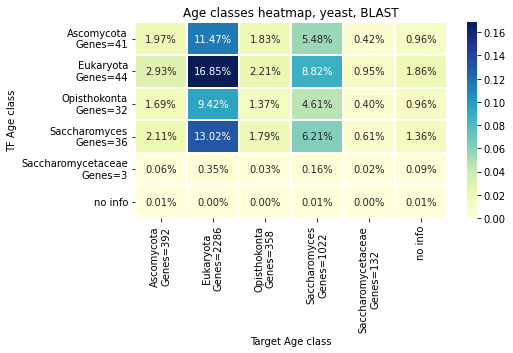

In [74]:
plt.rcParams["figure.figsize"] = 7, 3.6

xlabels = ['Ascomycota', 'Eukaryota', 'Opisthokonta', 'Saccharomyces', 'Saccharomycetaceae'] # labels for x-axis
ylabels = ['Ascomycota', 'Eukaryota', 'Opisthokonta', 'Saccharomyces', 'Saccharomycetaceae'] # labels for y-axis
    
x_axis_labels = []
y_axis_labels = []

for label in xlabels:
    x_axis_labels.append(f'{label}\nGenes={tg_ages_count[tg_ages_count.Tg_age == label].Tg.iloc[0]}')
    
x_axis_labels.append('no info')
    
for label in ylabels:
    y_axis_labels.append(f'{label}\nGenes={tf_ages_count[tf_ages_count.Tf_age == label].Tf.iloc[0]}')

y_axis_labels.append('no info')

s = sns.heatmap(heatmap_y,
                xticklabels=x_axis_labels, 
                yticklabels=y_axis_labels,
                annot=True, 
                fmt=".2%",
                cmap="YlGnBu",
                linewidths=1.5)

s.set(xlabel='Target Age class', ylabel='TF Age class')
plt.title('Age classes heatmap, yeast, BLAST')

#plt.savefig('../data/04_plots/yeast_swiss_blast_heatmap.png')
#plt.close()

In [61]:
classes = ['no info', 'Eukaryota', 'Opisthokonta', 'Ascomycota', 'Saccharomycetaceae', 'Saccharomyces']

yeast_data['Tg_age_int'] = yeast_data['Tg_age'].apply(lambda x: classes.index(x))
yeast_data['TF_age_int'] = yeast_data['Tf_age'].apply(lambda x: classes.index(x))


yeast_data['age_length'] = np.where((yeast_data['TF_age_int'] == 0) | (yeast_data['Tg_age_int'] == 0),
                                     -1,
                                     abs(yeast_data['TF_age_int'] - yeast_data['Tg_age_int']))

# no info to NAN
yeast_data['age_length'] = yeast_data['age_length'].replace({-1: np.nan})

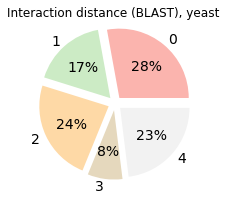

In [72]:
plt.rcParams["figure.figsize"] = 3, 3

idx = [0, 1, 2, 3, 4]
counts = pd.Series(yeast_data['age_length'].value_counts(normalize=True) * 100)
counts.index = counts.index.astype('int64')
counts = counts[idx]

explode = (0.1, 0.1, 0.1, 0.1, 0.1)
counts.plot(kind='pie', fontsize=14, colormap="Pastel1", explode=explode,  autopct='%.0f%%')
plt.axis('equal')
plt.ylabel('')
plt.title('Interaction distance (BLAST), yeast')

plt.show()
#plt.savefig('../data/04_plots/yeast_pie.png')
#plt.close()

In [65]:
ages_list = ['Eukaryota', 'Opisthokonta', 'Ascomycota', 'Saccharomycetaceae', 'Saccharomyces',  'no info']
tf_tg_count = heatmap_y.copy()

for tf_age in ages_list:
    for tg_age in ages_list:
        new_table = yeast_data[(yeast_data.Tg_age == tg_age) & (yeast_data.Tf_age == tf_age)]
        if new_table[['Tf']].nunique().iloc[0] != 0:
            new_value = new_table[['Tg']].nunique().iloc[0] / new_table[['Tf']].nunique().iloc[0]
        else:
            new_value = 0
        tf_tg_count.loc[tf_age, tg_age] = new_value

In [66]:
tf_tg_count

Tg_age,Ascomycota,Eukaryota,Opisthokonta,Saccharomyces,Saccharomycetaceae,no info
Tf_age,,,,,,
Ascomycota,5.294118,24.675000,4.611111,13.514286,2.150000,3.142857
Eukaryota,5.536585,30.000000,4.641026,14.547619,2.176471,3.184211
Opisthokonta,5.960000,27.806452,5.565217,14.407407,2.388889,3.458333
Saccharomyces,5.787879,32.861111,5.483871,15.257143,2.240000,4.571429
Saccharomycetaceae,2.666667,15.000000,4.000000,10.000000,2.000000,5.500000
no info,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000


Text(0.5, 1.0, 'TG/TF heatmap, yeast')

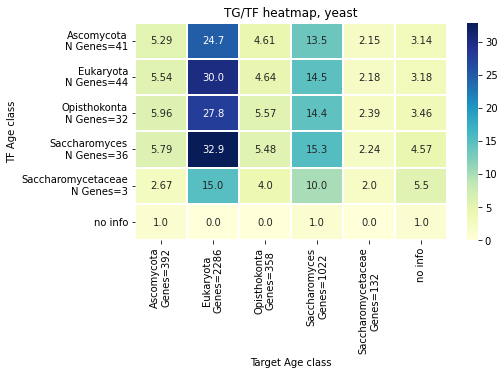

In [76]:
plt.rcParams["figure.figsize"] = 7, 4

xlabels = ['Ascomycota', 'Eukaryota', 'Opisthokonta', 'Saccharomyces', 'Saccharomycetaceae'] # labels for x-axis
ylabels = ['Ascomycota', 'Eukaryota', 'Opisthokonta', 'Saccharomyces', 'Saccharomycetaceae'] # labels for y-axis
    
x_axis_labels = []
y_axis_labels = []

for label in xlabels:
    x_axis_labels.append(f'{label}\nGenes={tg_ages_count[tg_ages_count.Tg_age == label].Tg.iloc[0]}')
    
x_axis_labels.append('no info')
    
for label in ylabels:
    y_axis_labels.append(f'{label}\nN Genes={tf_ages_count[tf_ages_count.Tf_age == label].Tf.iloc[0]}')

y_axis_labels.append('no info')

s = sns.heatmap(tf_tg_count,
                xticklabels=x_axis_labels, 
                yticklabels=y_axis_labels,
                annot=True, 
                fmt=".3",
                cmap="YlGnBu",
                linewidths=1.5)

s.set(xlabel='Target Age class', ylabel='TF Age class')
plt.title('TG/TF heatmap, yeast')

#plt.savefig('../data/04_plots/yeast_swiss_blast_heatmap_02.png')
#plt.close()



# DB analysis

In [ ]:
# Get file with sequence - class in red swiss base
# take ~5 min

fasta_sequences = SeqIO.parse(open('../data/04_blast_db/reduced_swiss/swiss_red_uniq.fa'),'fasta')
db_ages = pd.DataFrame(columns=['id', 'Groups', 'Final_group'])
i = 0

for fasta in fasta_sequences:
    name, description = fasta.id, fasta.description
    db_ages.loc[name] = [name, re.findall('(?<!Full\=)\[(.*?)\]', description), None]
    print(f'{i} from 94315, {round( (i * 100 / 94315), 2)}')
    i += 1

In [72]:
for index, row in db_ages.iterrows():
    for group in row.Groups:
        new_species = group.split()
        if len(new_species) > 1:
            new_species = '_'.join(new_species[:2])
            if new_species in ages_for_node:
                row['Final_group'] = ages_for_node[new_species]

# check when add to set -- select more big group
db_ages.loc['P61830.2', 'Final_group'] = 'Saccharomycetaceae'

In [94]:
swiss_red_db_ages = db_ages.groupby('Final_group', as_index=0).count()[['Final_group', 'id']]
swiss_red_db_ages.loc["Total"] = swiss_red_db_ages.sum()
swiss_red_db_ages.loc['Total', 'Final_group'] = 'Total'
swiss_red_db_ages.rename(columns = {'Final_group':'Age class', 'id': 'Seq number'}, inplace = True)
swiss_red_db_ages

,Age class,Seq number
0,Ascomycota,5106
1,Eukaryota,25332
2,Opisthokonta,55622
3,Saccharomyces,7281
4,Saccharomycetaceae,927
Total,Total,94268
